In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Communication Services 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data

,date,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Communication Services (Sector) Performance (%),S&P 500 Communication Services (Sector) Outperform/Underperform,overall,communication,information technology commodities,education and communication commodities,education and communication services
4178,2009-12-02,1109.24,112.279999,-2.929002,-7.006791,UNDERPERFORM,217.488,84.972,100.047,100.150,100.083
4179,2009-12-03,1099.92,112.510002,-3.497166,-7.100982,UNDERPERFORM,217.488,84.972,100.047,100.150,100.083
4180,2009-12-04,1105.98,112.750000,-2.494975,-6.795074,UNDERPERFORM,217.488,84.972,100.047,100.150,100.083
4181,2009-12-07,1103.25,114.540001,-1.918512,-4.843401,UNDERPERFORM,217.488,84.972,100.047,100.150,100.083
4182,2009-12-08,1091.94,113.620003,-4.938755,-6.431687,UNDERPERFORM,217.488,84.972,100.047,100.150,100.083
...,...,...,...,...,...,...,...,...,...,...,...
7194,2021-11-24,4701.46,271.019989,19.548197,51.976665,OUTPERFORM,280.126,76.330,47.997,67.834,116.681
7195,2021-11-26,4594.62,265.980011,16.437110,48.600482,OUTPERFORM,280.126,76.330,47.997,67.834,116.681
7196,2021-11-29,4655.27,268.959991,19.324593,51.868990,OUTPERFORM,280.126,76.330,47.997,67.834,116.681
7197,2021-11-30,4567.00,260.899994,17.908879,48.196529,OUTPERFORM,280.126,76.330,47.997,67.834,116.681


## Using all data

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Communication Services (Sector) Performance (%),S&P 500 Communication Services (Sector) Outperform/Underperform,overall,communication,information technology commodities,education and communication commodities,education and communication services,dow
0,2009,12,2009-12-10,1102.35,114.449997,-3.951381,-6.632407,UNDERPERFORM,217.488,84.972,100.047,100.150,100.083,3
1,2010,1,2010-01-14,1148.46,108.800003,-2.941027,-10.378912,UNDERPERFORM,217.281,84.849,99.258,99.904,100.205,3
2,2010,2,2010-02-11,1078.47,103.440002,-9.326551,-14.278608,UNDERPERFORM,217.353,84.868,99.067,99.781,100.441,3
3,2010,3,2010-03-11,1150.24,106.089996,-8.476491,-16.824780,UNDERPERFORM,217.403,84.840,98.406,99.447,100.672,3
4,2010,4,2010-04-08,1186.44,107.980003,-7.551331,-13.227257,UNDERPERFORM,217.290,84.738,97.553,99.069,100.829,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2021,7,2021-07-08,4320.82,265.809998,1.147999,28.734019,OUTPERFORM,273.092,76.056,48.787,68.796,115.826,3
140,2021,8,2021-08-12,4460.83,276.720001,7.276877,37.843089,OUTPERFORM,274.214,76.337,49.162,69.155,116.228,3
141,2021,9,2021-09-09,4493.28,285.880005,15.209058,47.254562,OUTPERFORM,276.590,76.407,48.847,68.823,116.446,3
142,2021,10,2021-10-14,4438.26,271.589996,8.483351,41.896554,OUTPERFORM,278.524,76.317,48.278,68.130,116.565,3


In [4]:
original = data[['S&P 500 Communication Services (Sector) Outperform/Underperform','month','overall','communication',\
                'information technology commodities','education and communication commodities',\
                'education and communication services']]

In [5]:
data.drop(columns=['date','S&P 500 Communication Services (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Communication Services (Sector) Performance (%),overall,communication,information technology commodities,education and communication commodities,education and communication services,dow
0,12,1102.35,114.449997,-3.951381,-6.632407,217.488,84.972,100.047,100.150,100.083,3
1,1,1148.46,108.800003,-2.941027,-10.378912,217.281,84.849,99.258,99.904,100.205,3
2,2,1078.47,103.440002,-9.326551,-14.278608,217.353,84.868,99.067,99.781,100.441,3
3,3,1150.24,106.089996,-8.476491,-16.824780,217.403,84.840,98.406,99.447,100.672,3
4,4,1186.44,107.980003,-7.551331,-13.227257,217.290,84.738,97.553,99.069,100.829,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Communication Services (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','communication',\
                'information technology commodities','education and communication commodities',\
                'education and communication services']]

In [7]:
dd.data_summary(original)

,Info
Rows,144
Columns,7
Size in Memory,8.0 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.56,0.50,2,81
month,int64,0,0,1,6.50,12,6.50,3.45,12,12
overall,float64,0,0,217.20,238.025,280.13,241.74,14.75,142,2
communication,float64,0,0,72.92,79.92,84.97,78.97,4.10,142,2
information technology commodities,float64,0,0,46.58,61.98,100.047,66.77,15.78,144,1
education and communication commodities,float64,0,0,66.13,81.50,100.15,82.43,10.090,144,1
education and communication services,float64,0,0,100.083,109.15,116.68,108.65,4.11,144,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

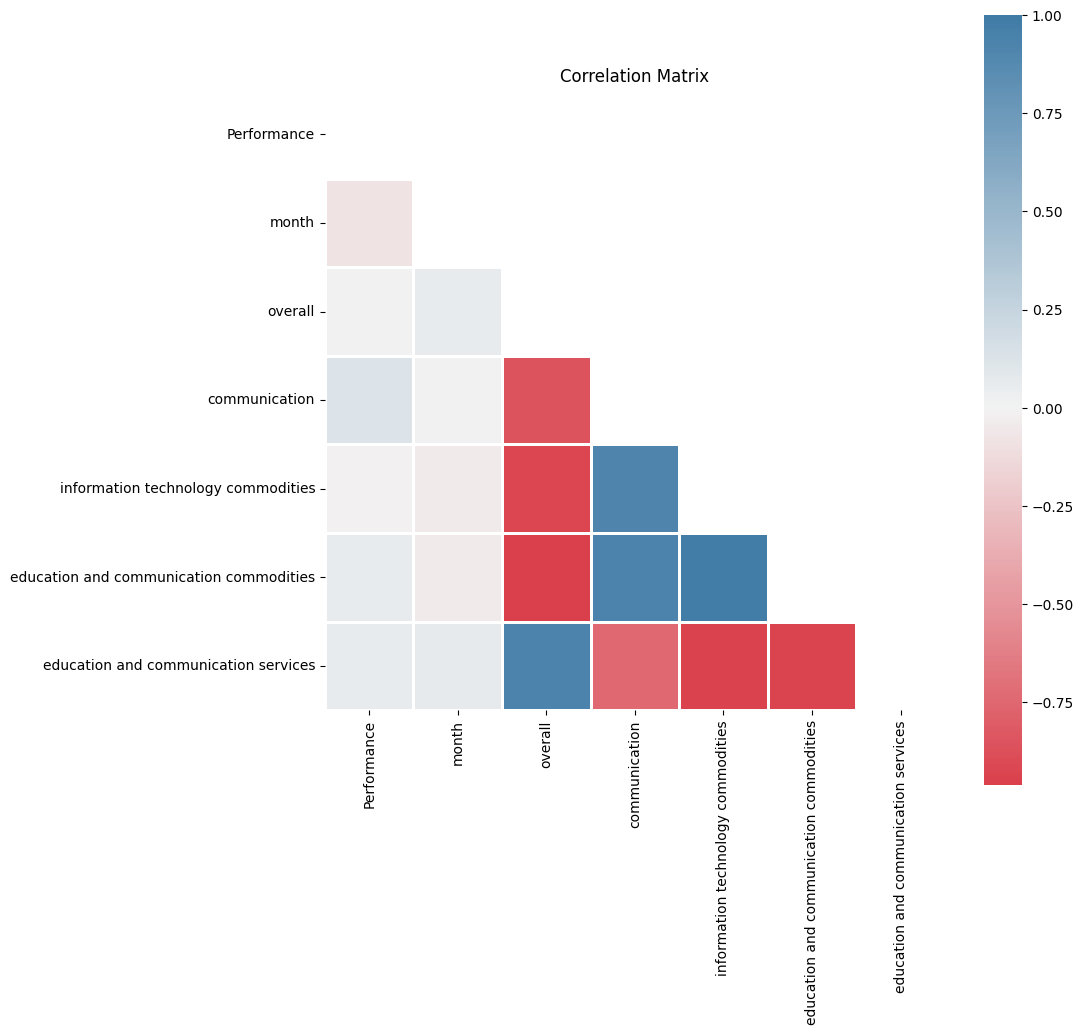

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Communication Services (Sector) Performance (%),overall,communication,information technology commodities,education and communication commodities,education and communication services,dow
0,4,1000.323969,112.811547,-16.226244,-12.741236,232.221394,82.196595,95.419705,100.149383,101.148824,3
1,7,2086.435139,162.895419,-9.596118,-3.719532,230.918801,73.287764,63.347245,76.246071,108.750570,3
2,6,2788.170364,166.194408,-10.837475,-17.638517,256.488933,75.472002,50.156084,74.722051,114.119870,3
3,8,1725.158098,149.904858,3.802776,2.342999,245.558179,81.041067,87.876946,77.180897,105.119125,3
4,12,2469.046561,147.648629,-11.821020,-5.773822,233.002714,72.482904,71.491629,72.806297,110.116823,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,5,1887.967540,137.966556,-12.325488,-4.389809,254.334744,80.193804,53.524751,92.109736,109.693580,3
9996,9,3349.671152,154.729606,5.493872,0.754869,236.202497,80.550348,59.228339,79.889694,109.567146,3
9997,9,2283.057489,157.972490,-6.863672,0.374957,255.805078,74.170565,51.999647,76.658305,109.737374,3
9998,4,1482.633447,141.650589,-10.563058,5.429203,249.967642,81.069781,52.123554,75.442430,109.306626,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Communication Services (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month', 'overall','communication',\
                'information technology commodities','education and communication commodities',\
                'education and communication services']]
samples.head()

,Performance,month,overall,communication,information technology commodities,education and communication commodities,education and communication services
0,1,4,232.221394,82.196595,95.419705,100.149383,101.148824
1,1,7,230.918801,73.287764,63.347245,76.246071,108.750570
2,0,6,256.488933,75.472002,50.156084,74.722051,114.119870
3,0,8,245.558179,81.041067,87.876946,77.180897,105.119125
4,1,12,233.002714,72.482904,71.491629,72.806297,110.116823


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,7
Size in Memory,547.0 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.66,0.47,2,6626
month,int64,0,0,1,7,12,6.46,3.44,12,866
overall,float64,0,0,203.00,235.51,284.28,239.098,15.17,10000,1
communication,float64,0,0,71.49,80.31,87.57,78.94,4.16,10000,1
information technology commodities,float64,0,0,37.016,64.54,120.98,67.078,16.23,10000,1
education and communication commodities,float64,0,0,56.72,83.061,111.20,83.40,11.20,9999,2
education and communication services,float64,0,0,97.88,109.29,119.36,108.41,4.47,10000,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

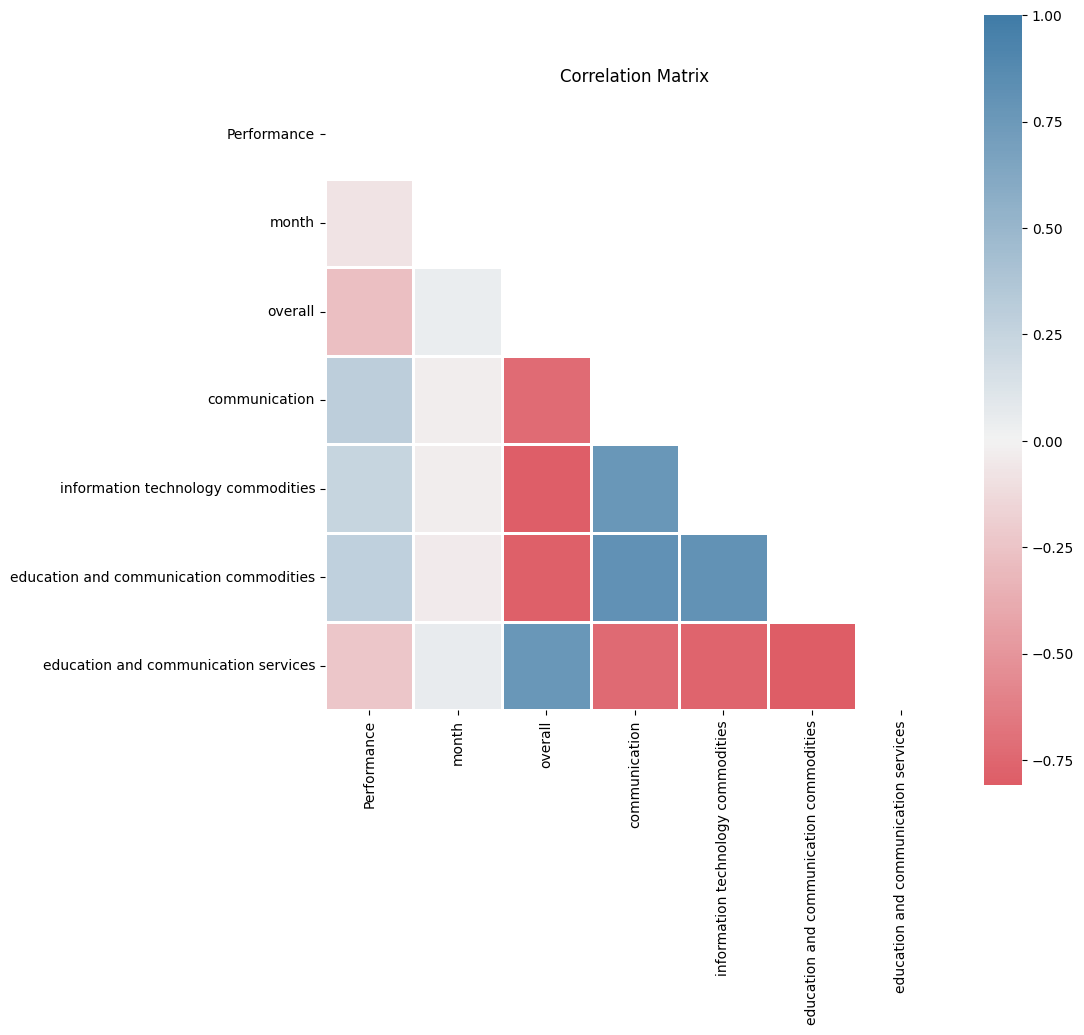

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({1: 6626, 0: 3374})
Counter({1: 6626, 0: 6626})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[  232.22139357,    82.19659534,    95.41970483, ...,
         9556.22460069,  9651.5909142 , 10129.99233576],
       [  230.91880108,    73.28776382,    63.34724482, ...,
         4829.97855157,  6889.04897006,  8291.80371014],
       [  256.48893332,    75.47200236,    50.15608352, ...,
         3747.76545501,  5723.80572753,  8527.27079758],
       ...,
       [  225.13526067,    80.78729326,    55.03748638, ...,
         4102.19036543,  5861.82261988,  7938.3693355 ],
       [  232.66878243,    81.30420213,    82.16610447, ...,
         7704.12036446,  8497.6192183 ,  9696.94496651],
       [  258.67076538,    74.48991582,    47.74687914, ...,
         3437.96761514,  5301.87219234,  7995.41582336]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(13252, 16)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(144, 16)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.741251,0.790186,0.6627,0.720001,0.725928,0.77554,0.643967,0.703655,0.604167,0.642857,0.666667,0.654545
1,DecisionTreeClassifier,0.700127,0.713193,0.675676,0.693261,0.679445,0.69197,0.658901,0.675031,0.590278,0.630952,0.654321,0.642424
2,RandomForestClassifier,0.792565,0.818115,0.75883,0.786317,0.764866,0.78485,0.736559,0.759938,0.569444,0.602151,0.691358,0.643678
3,AdaBoostClassifier,0.713027,0.703889,0.736195,0.719552,0.713855,0.705549,0.744325,0.724419,0.520833,0.566667,0.62963,0.596491
4,GradientBoostingClassifier,0.723364,0.714379,0.745249,0.729386,0.721401,0.717934,0.738949,0.72829,0.5625,0.597826,0.679012,0.635838
5,ExtraTreesClassifier,0.814599,0.846529,0.775278,0.80807,0.784787,0.812216,0.746714,0.778089,0.555556,0.597701,0.641975,0.619048
6,BaggingClassifier,0.752192,0.797466,0.681561,0.734101,0.732569,0.775524,0.662485,0.714562,0.583333,0.632911,0.617284,0.625
7,SVC,0.695216,0.689269,0.71144,0.70012,0.706007,0.705882,0.716846,0.711322,0.590278,0.627907,0.666667,0.646707
8,GaussianNB,0.663749,0.671983,0.640654,0.655806,0.676426,0.693196,0.645161,0.668317,0.520833,0.578947,0.54321,0.56051


### Voting Classifier

In [21]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.771204,0.790978,0.743728,0.766626
